In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import pickle

# NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv("C:\\Users\\Lenovo\\Downloads\\archive (2)\\spam.csv", encoding='latin-1')

# Initial inspection
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

# Encode target labels
df['target'] = df['target'].map({'ham': 0, 'spam': 1})

# Drop duplicates
df.drop_duplicates(keep='first', inplace=True)


(5169, 2)
   target                                               text
0       0  Go until jurong point, crazy.. Available only ...
1       0                      Ok lar... Joking wif u oni...
2       1  Free entry in 2 a wkly comp to win FA Cup fina...
3       0  U dun say so early hor... U c already then say...
4       0  Nah I don't think he goes to usf, he lives aro...


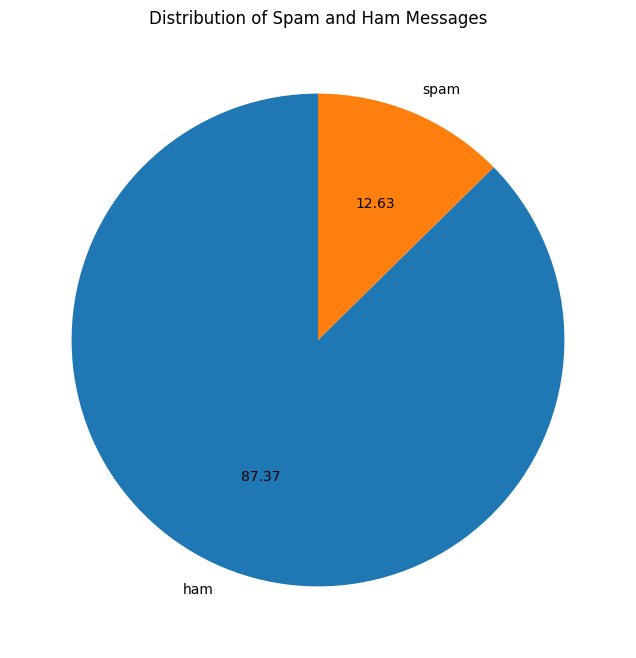

       num_characters  num_sentences    num_words
count     5169.000000    5169.000000  5169.000000
mean        78.977945       1.965564    18.455794
std         58.236293       1.448541    13.324758
min          2.000000       1.000000     1.000000
25%         36.000000       1.000000     9.000000
50%         60.000000       1.000000    15.000000
75%        117.000000       2.000000    26.000000
max        910.000000      38.000000   220.000000
       num_characters  num_sentences    num_words
count     4516.000000    4516.000000  4516.000000
mean        70.459256       1.820195    17.123782
std         56.358207       1.383657    13.493970
min          2.000000       1.000000     1.000000
25%         34.000000       1.000000     8.000000
50%         52.000000       1.000000    13.000000
75%         90.000000       2.000000    22.000000
max        910.000000      38.000000   220.000000


In [3]:
# Final shape and head
print(df.shape)
print(df.head())

# Pie chart of target distribution
plt.figure(figsize=(8, 8))
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f", startangle=90, colors=['#1f77b4', '#ff7f0e'])
plt.title('Distribution of Spam and Ham Messages')
plt.show()

# Add character, word, and sentence counts
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Descriptive statistics
print(df[['num_characters', 'num_sentences', 'num_words']].describe())
print(df[df['target'] == 0][['num_characters', 'num_sentences', 'num_words']].describe())


C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na 

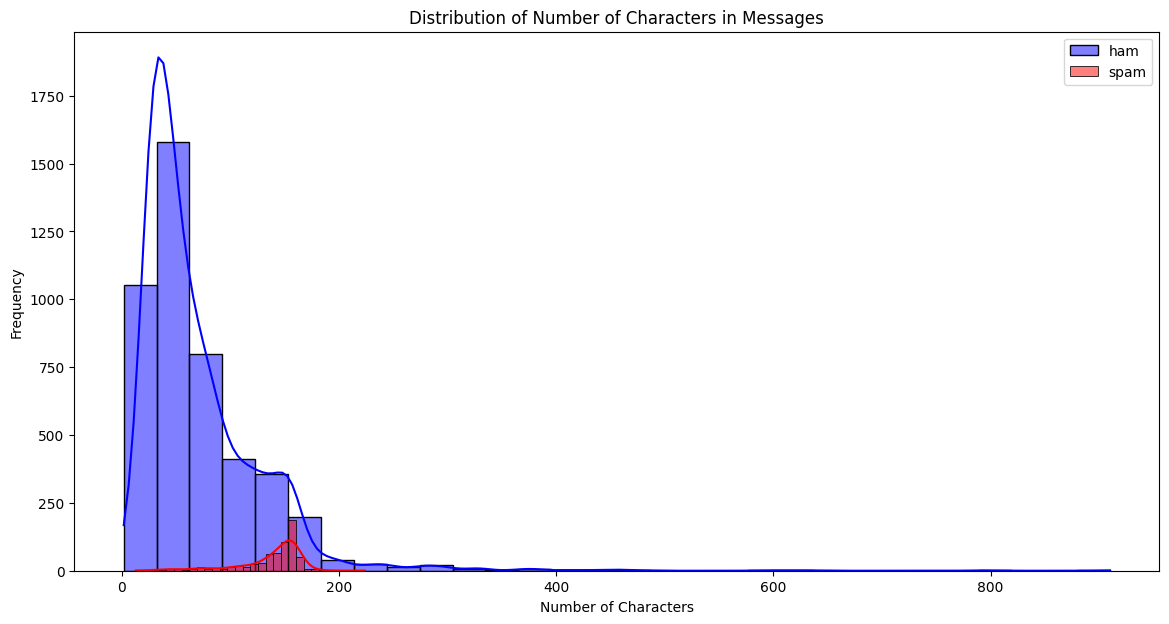

C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

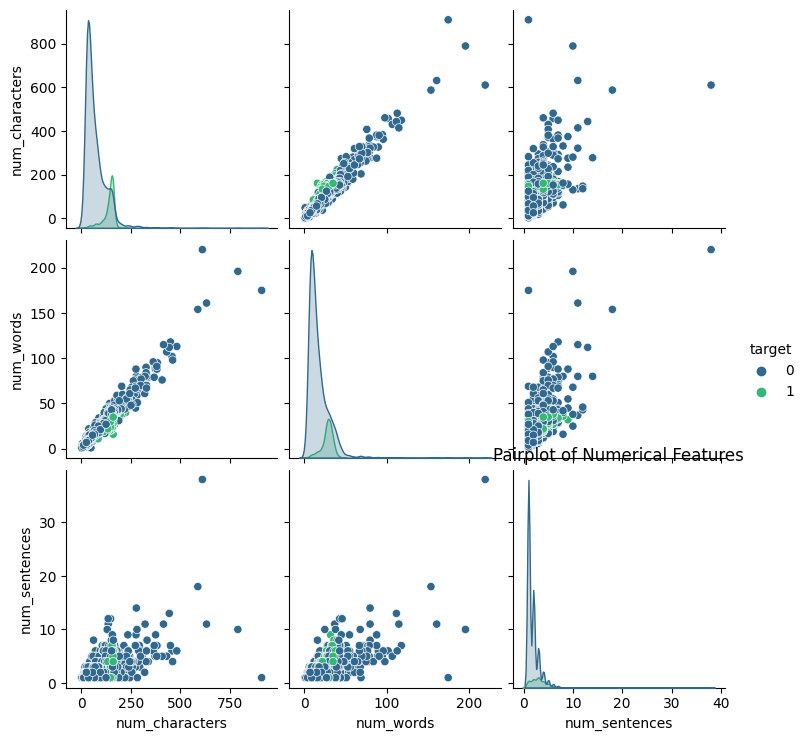

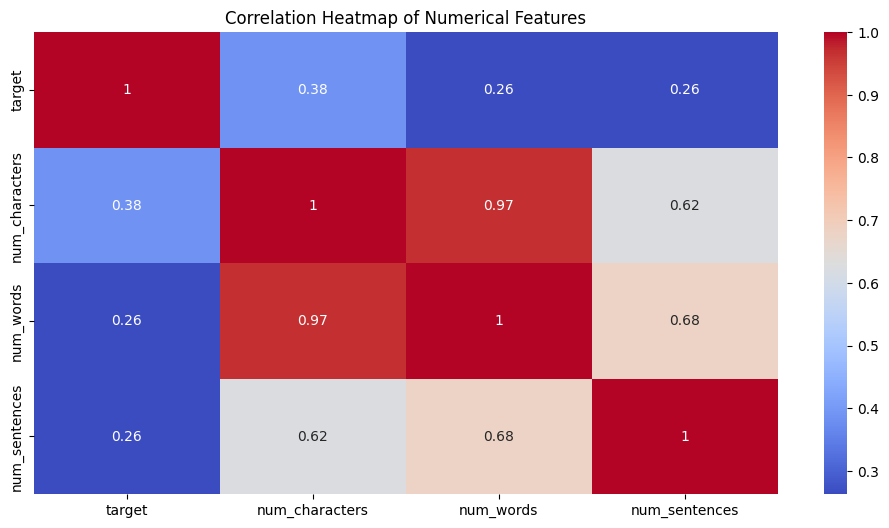

In [4]:
# Histograms
plt.figure(figsize=(14, 7))
sns.histplot(df[df['target'] == 0]['num_characters'], color='blue', label='ham', kde=True, bins=30)
sns.histplot(df[df['target'] == 1]['num_characters'], color='red', label='spam', kde=True, bins=30)
plt.legend()
plt.title('Distribution of Number of Characters in Messages')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Pairplot
sns.pairplot(df, hue='target', palette='viridis')
plt.title('Pairplot of Numerical Features')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 6))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


In [ ]:
# Text preprocessing
def transform_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    ps = PorterStemmer()
    cleaned_tokens = [ps.stem(token) for token in tokens if token.isalnum() and token not in stopwords.words('english')]
    return " ".join(cleaned_tokens)

df['transformed_text'] = df['text'].apply(transform_text)
print(df.head())


In [ ]:
# Word Cloud for spam and ham messages
spam_text = df[df['target'] == 1]['transformed_text'].str.cat(sep=" ")
wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(spam_text)
plt.figure(figsize=(18, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages', fontsize=15)
plt.show()

ham_text = df[df['target'] == 0]['transformed_text'].str.cat(sep=" ")
wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(ham_text)
plt.figure(figsize=(18, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages', fontsize=15)
plt.show()

# Common words in spam and ham
spam_corpus = [word for msg in df[df['target'] == 1]['transformed_text'] for word in msg.split()]
spam_word_counts = Counter(spam_corpus)
spam_common_words_df = pd.DataFrame(spam_word_counts.most_common(30), columns=['Word', 'Count'])

plt.figure(figsize=(14, 7))
sns.barplot(x='Count', y='Word', data=spam_common_words_df, palette='viridis')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.title('Top 30 Most Common Words in Spam Messages', fontsize=15)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show()

ham_corpus = [word for msg in df[df['target'] == 0]['transformed_text'] for word in msg.split()]
ham_word_counts = Counter(ham_corpus)
ham_common_words_df = pd.DataFrame(ham_word_counts.most_common(30), columns=['Word', 'Count'])

plt.figure(figsize=(14, 7))
sns.barplot(x='Count', y='Word', data=ham_common_words_df, palette='viridis')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.title('Top 30 Most Common Words in Ham Messages', fontsize=15)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show()


In [ ]:
# Feature extraction
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Model training and evaluation
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'conf_matrix': conf_matrix
    }

    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")


In [ ]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Ham', 'Predicted Spam'],
                yticklabels=['Actual Ham', 'Actual Spam'], cbar=False)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(title, fontsize=15)
    plt.show()

# Plot confusion matrices for each model
for model_name, result in results.items():
    plot_confusion_matrix(result['conf_matrix'], f"Confusion Matrix for {model_name}")

# Save the best model and vectorizer
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"Best model: {best_model_name}")
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(models[best_model_name], open('model.pkl', 'wb'))

# Function to predict if a message is 'ham' or 'spam'
def predict_message(text):
    transformed_text = transform_text(text)  # Transform the input text
    vectorized_text = tfidf.transform([transformed_text]).toarray()  # Vectorize the transformed text
    prediction = models[best_model_name].predict(vectorized_text)[0]  # Predict using the best model
    return 'ham' if prediction == 0 else 'spam'



In [ ]:
example_text_ham = "Hi, how are you? Let's catch up soon!"
example_text_spam = "You have won $1000! Click here to claim your prize."

print(f"Message: '{example_text_ham}' is classified as '{predict_message(example_text_ham)}'")
print(f"Message: '{example_text_spam}' is classified as '{predict_message(example_text_spam)}'")